# Equipe
* ### Lucas de Farias Teixeira
* ### Gustavo Campestrini
* ### Nicolas Ceruti
<hr>

## Observação:
#### No Jupyter Notebook, os grafos quando desenhados podem ser difíceis de analisar, pois a imagem fica muito pequena.
#### Para uma análise melhor, recomendamos executar o código diretamente pelo Python (com um script .py), dessa forma uma janela interativa será disponibilizada para ajudar na análise, permitindo dar zoom no grafo para conferir os detalhes das conexões de perto.
##### O script Python (.py) está na mesma pasta que esse arquivo.
<hr>

### Imports e definição de variáveis e funções

In [17]:
"""
EQUIPE:
 - LUCAS DE FARIAS TEIXEIRA
 - GUSTAVO CAMPESTRINI
 - NICOLAS CERUTI
"""
import xmltodict
import os
import networkx as nx
import unicodedata
import matplotlib.pyplot as plt
import re
import community.community_louvain as community_louvain
from typing import Literal

# consts
MESTRADO = "MESTRADO"
DOUTORADO = "DOUTORADO"

# caminho dos curriculos no sistema de arquivos
basepath = "/home/magalu/sandbox/graphs/curriculos/"

# inicializa algumas variaveis necessarias para a execucao
curriculos = []
todos_pesquisadores = {}
todos_autores = {}
todos_orientados_mestrado = {}
todos_orientados_doutorado = {}
bases_orientados = {
    MESTRADO: todos_orientados_mestrado,
    DOUTORADO: todos_orientados_doutorado,
}
coautoria_frequente = {}
label_list = {}
pesquisadores_node_list = []
autores_node_list = []
orientados_mestrado_node_list = []
orientados_doutorado_node_list = []
autores_orientados_node_list = []
id_cont = 1


def remove_acentos(texto: str) -> str:
    """
    Remove acentos do texto

    Args:
        texto (str): Texto para remover os acentos.

    Returns:
        str: Texto sem acentos

    Obs: Utiliza o encoding ISO-8859-1 por estar lidando com XMLs que utilizam esse padrão
    """
    nfkd_form = unicodedata.normalize('NFKD', texto)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode(encoding="iso-8859-1")


def normaliza_nome(nome: str) -> str:
    nome = remove_acentos(nome).lower().replace("-", " ")
    if "," in nome:
        nomes = nome.split(",")
        nome = nomes[1].strip() + " " + nomes[0].strip()
        
    return nome


def autor_ou_pesquisador_existe_na_base(id: str, nome: str, nomes_citacao: list[str], base: dict):
    for k, v in base.items():
        nomes = nome.split()
        primeiro_nome = nomes[0]
        sobrenome = nomes[-1]
        pattern = f"{primeiro_nome} ([a-z]+ )*{sobrenome}( [a-z]+ ?)*"
        nomes_citacao_em_comum = len(set(v["nomes_citacao"]).intersection(set(nomes_citacao)))
        if k == nome or re.search(pattern, k) or nomes_citacao_em_comum > 0 or v["id"] == id:
            return k, True
        
    return "", False


def nome_existe_na_base(nome: str, base: dict):
    for k in base.keys():
        nomes = nome.split()
        primeiro_nome = nomes[0]
        sobrenome = nomes[-1]
        pattern = f"{primeiro_nome} ([a-z]+ )*{sobrenome}( [a-z]+ ?)*"
        if k == nome or re.search(pattern, k):
            return k, True
        
    return "", False


def pesquisa_orientado_nas_bases(nome: str) -> str:
    nome_encontrado, ok = nome_existe_na_base(nome, todos_pesquisadores)
    if ok:
        return nome_encontrado
    
    nome_encontrado, ok = nome_existe_na_base(nome, todos_autores)
    if ok:
        return nome_encontrado
    
    nome_encontrado, ok = nome_existe_na_base(nome, todos_orientados_mestrado)
    if ok:
        return nome_encontrado
    
    nome_encontrado, ok = nome_existe_na_base(nome, todos_orientados_doutorado)
    if ok:
        return nome_encontrado

    return nome

def busca_ou_registra_autor(autor: dict) -> dict:
    """
    Procura o autor dentro do dicionário 'todos_autores', se baseando em seus nomes para citação, seu ID e seu nome.
    Como os nomes podem possuir várias variações, são feitas algumas verificações (que não garantem a não duplicidade do mesmo indivíduo).
    Caso o autor não seja encontrado, ele é inserido no dicionário.
    Por fim, o nome do autor são retornados pela função.

    Args:
        autor (str): Autor para ser procurado ou registrado.

    Returns:
        str: Nome do autor.
    """
    global id_cont
    id = autor["@NRO-ID-CNPQ"]
    nome_autor = normaliza_nome(autor["@NOME-COMPLETO-DO-AUTOR"])
    nomes_citacao = remove_acentos(autor["@NOME-PARA-CITACAO"]).replace("-", " ").split(";")
    nome, ok = autor_ou_pesquisador_existe_na_base(id, nome_autor, nomes_citacao, todos_pesquisadores)
    if ok:
        return nome
    
    nome, ok = autor_ou_pesquisador_existe_na_base(id, nome_autor, nomes_citacao, todos_autores)
    if ok:
        return nome
    
    id = autor["@NRO-ID-CNPQ"]
    if id == "":
        id = str(id_cont)
        id_cont += 1

    autor_obj = {"id": id, "nomes_citacao": nomes_citacao} 
    todos_autores[nome_autor] = autor_obj
    return nome_autor
            

def formata_autores(items: list[dict] | dict) -> list[dict]:
    """
    Recebe o(s) autor(es) e retorna em um formato reduzido, apenas com as informações necessárias.

    Args:
        items (list(dict) | dict): Um ou mais autores para serem formatados

    Returns:
        list(dict): Nomes formatados dos autores.
    """
    if isinstance(items, dict):
        items = [items]
    
    return [busca_ou_registra_autor(autor) for autor in items]


def formata_artigos(items: list[dict] | dict) -> list[dict]:
    """
    Recebe o(s) artigo(s) e retorna em um formato reduzido, apenas com as informações necessárias.

    Args:
        items (list(dict) | dict): Um ou mais artigos para serem formatados

    Returns:
        list(dict): Artigos formatos com informações reduzidas e padronizadas.
    """
    if isinstance(items, dict):
        return [{"titulo": items["DADOS-BASICOS-DO-ARTIGO"]["@TITULO-DO-ARTIGO"], "autores": formata_autores(items["AUTORES"])}]
    
    artigos = []
    for artigo in items:
        artigos.append(
            {
                "titulo": artigo["DADOS-BASICOS-DO-ARTIGO"]["@TITULO-DO-ARTIGO"],
                "autores": formata_autores(artigo["AUTORES"]),
            }
        )

    return artigos


def formata_orientacoes(items: list[dict] | dict, tipo: Literal["MESTRADO", "DOUTORADO"]) -> list[dict]:
    """
    Recebe a(s) orientação(ões) e retorna em um formato reduzido, apenas com as informações necessárias.

    Args:
        items (list(dict) | dict): Uma ou mais orientações para serem formatados
        tipo (Literal["MESTRADO", "DOUTORADO"]): O tipo das orientações

    Returns:
        list(dict): Orientações formatos com informações reduzidas e padronizadas.
    """
    base = bases_orientados[tipo]

    if isinstance(items, dict):
        items = [items]
    
    orientacoes = []
    for orientacao in items:
        titulo = orientacao[f"DADOS-BASICOS-DE-ORIENTACOES-CONCLUIDAS-PARA-{tipo}"]["@TITULO"]
        nome = normaliza_nome(orientacao[f"DETALHAMENTO-DE-ORIENTACOES-CONCLUIDAS-PARA-{tipo}"]["@NOME-DO-ORIENTADO"])
        nome = pesquisa_orientado_nas_bases(nome)
        base[nome] = True
        orientacoes.append(
            {
                "titulo": titulo,
                "orientado": nome,
            }
        )
        
    return orientacoes


def inicia_pesquisadores(curriculos: list[dict]) -> None:
    """
    Insere os pesquisadores dos currículos fornecidos no dicionário 'todos_autores'.
    Essa inserção é feita para registrar o nome fornecido nos currículos, o que depois facilita a inserção de vértices com cores
    diferentes, que permitem destacar esses pesquisadores.

    Args:
        curriculos (list[str]): Curriculos dos pesquisadores que são base do trabalho.
    """
    for curriculo in curriculos:
        id = curriculo["CURRICULO-VITAE"]["@NUMERO-IDENTIFICADOR"]
        nome = normaliza_nome(curriculo["CURRICULO-VITAE"]["DADOS-GERAIS"]["@NOME-COMPLETO"])
        nomes_citacao = remove_acentos(curriculo["CURRICULO-VITAE"]["DADOS-GERAIS"]["@NOME-EM-CITACOES-BIBLIOGRAFICAS"]).split(";")
        todos_pesquisadores[nome] = {
            "id": id,
            "nomes_citacao": nomes_citacao,
            "artigos": [],
            "orientandos": {
                "mestrado": [],
                "doutorado": [],
            },
        }

        artigos = list(filter(lambda x: x["DADOS-BASICOS-DO-ARTIGO"]["@NATUREZA"] == "COMPLETO", curriculo["CURRICULO-VITAE"]["PRODUCAO-BIBLIOGRAFICA"]["ARTIGOS-PUBLICADOS"]["ARTIGO-PUBLICADO"]))
        todos_pesquisadores[nome]["artigos"] = formata_artigos(artigos)

        if (orientacoes := curriculo["CURRICULO-VITAE"]["OUTRA-PRODUCAO"]["ORIENTACOES-CONCLUIDAS"].get("ORIENTACOES-CONCLUIDAS-PARA-MESTRADO", False)):
            todos_pesquisadores[nome]["orientandos"]["mestrado"] = formata_orientacoes(orientacoes, "MESTRADO")
        
        if (orientacoes := curriculo["CURRICULO-VITAE"]["OUTRA-PRODUCAO"]["ORIENTACOES-CONCLUIDAS"].get("ORIENTACOES-CONCLUIDAS-PARA-DOUTORADO", False)):
            todos_pesquisadores[nome]["orientandos"]["doutorado"] = formata_orientacoes(orientacoes, "DOUTORADO")


def adiciona_aresta(g: nx.Graph, u: str, v: str):
    g.add_edge(u, v)


def adiciona_aresta_e_contabiliza_relacao(g: nx.Graph, u: str, v: str):
    g.add_edge(u, v)
    pair = tuple(sorted([u, v]))
    if pair in coautoria_frequente:
        coautoria_frequente[pair] += 1
    else:
        coautoria_frequente[pair] = 1


def adiciona_pesquisadores_ao_grafo(g: nx.Graph):
    # adiciona pesquisadores como nodes
    for k in todos_pesquisadores.keys():
        g.add_node(k)
        pesquisadores_node_list.append(k)
        label_list[k] = k


def adiciona_autores_ao_grafo(g: nx.Graph, contabiliza_relacoes: bool):
    funcoes_adicao_arestas = {
        True: adiciona_aresta_e_contabiliza_relacao,
        False: adiciona_aresta,
    }
    func_adiciona_aresta = funcoes_adicao_arestas[contabiliza_relacoes]
    # adiciona autores como nodes
    for v in todos_pesquisadores.values():
        for a in v["artigos"]:
            for i in a["autores"]:
                for j in a["autores"]:
                    if i == j:
                        continue

                    if not g.has_node(i):            
                        g.add_node(i, weight=1)
                        autores_node_list.append(i)

                    if not g.has_node(j):                  
                        g.add_node(j, weight=1)
                        autores_node_list.append(j)

                    func_adiciona_aresta(g, i, j)
                    

def adiciona_orientados_ao_grafo(g: nx.Graph):
    # adiciona orientados como nodes
    for k, v in todos_pesquisadores.items():
        for orientacao in v["orientandos"]["mestrado"]:
            if not g.has_node(orientacao["orientado"]):
                g.add_node(orientacao["orientado"], weight=1, orientador=k)
                orientados_mestrado_node_list.append(orientacao["orientado"])
                g.add_edge(k, orientacao["orientado"])

        for orientacao in v["orientandos"]["doutorado"]:
            if not g.has_node(orientacao["orientado"]):
                g.add_node(orientacao["orientado"], weight=1, orientador=k)
                orientados_doutorado_node_list.append(orientacao["orientado"])
                g.add_edge(k, orientacao["orientado"])


def retorna_cores_para_grafo_com_todos_os_individuos(g: nx.Graph):
    node_colors = []

    for node in g.nodes:
        is_pesquisador = node in todos_pesquisadores.keys()
        # Como o peesquisador sempre sera apenas pesquisador, definimos a cor na hora de desenhar (sera vermelho)
        if is_pesquisador:
            continue

        is_coautor = node in todos_autores.keys()
        is_mestrado = node in todos_orientados_mestrado.keys()
        is_doutorado = node in todos_orientados_doutorado.keys()

        if is_coautor and (is_mestrado or is_doutorado):
            node_colors.append("yellow")  # Coautor e orientado
            autores_orientados_node_list.append(node)
        elif is_coautor:
            node_colors.append("blue")  # Apenas coautor
        elif is_mestrado or is_doutorado:
            node_colors.append("green")  # Apenas orientado

    return node_colors


def limpa_listas():
    pesquisadores_node_list.clear()
    autores_node_list.clear()
    orientados_mestrado_node_list.clear()
    orientados_doutorado_node_list.clear()

### Carrega dados dos arquivos, formata e armazena nas estruturas

In [18]:
for filename in os.listdir(basepath):
    with open(basepath + filename, "r+", encoding="iso-8859-1") as file:
        curriculos.append(xmltodict.parse(file.read(), encoding="iso-8859-1"))

inicia_pesquisadores(curriculos)

### Instancia grafo e insere nodes e arestas para representar pesquisadores e co-autores

In [19]:
g_pesquisadores_autores = nx.Graph()
adiciona_pesquisadores_ao_grafo(g_pesquisadores_autores)
adiciona_autores_ao_grafo(g_pesquisadores_autores, True)

### Desenha grafo com os pesquisadores e co-autores

#### Define cores para os nodes de acordo com sua classificação
Legenda dos nodes:
* Pesquisadores Analisados -> amarelo
* Co-autores -> azul

Obs: Caso queira analisar o grafo junto com o nome dos pesquisadores analisados (vértices amarelos), basta descomentar a linha de código comentada no bloco

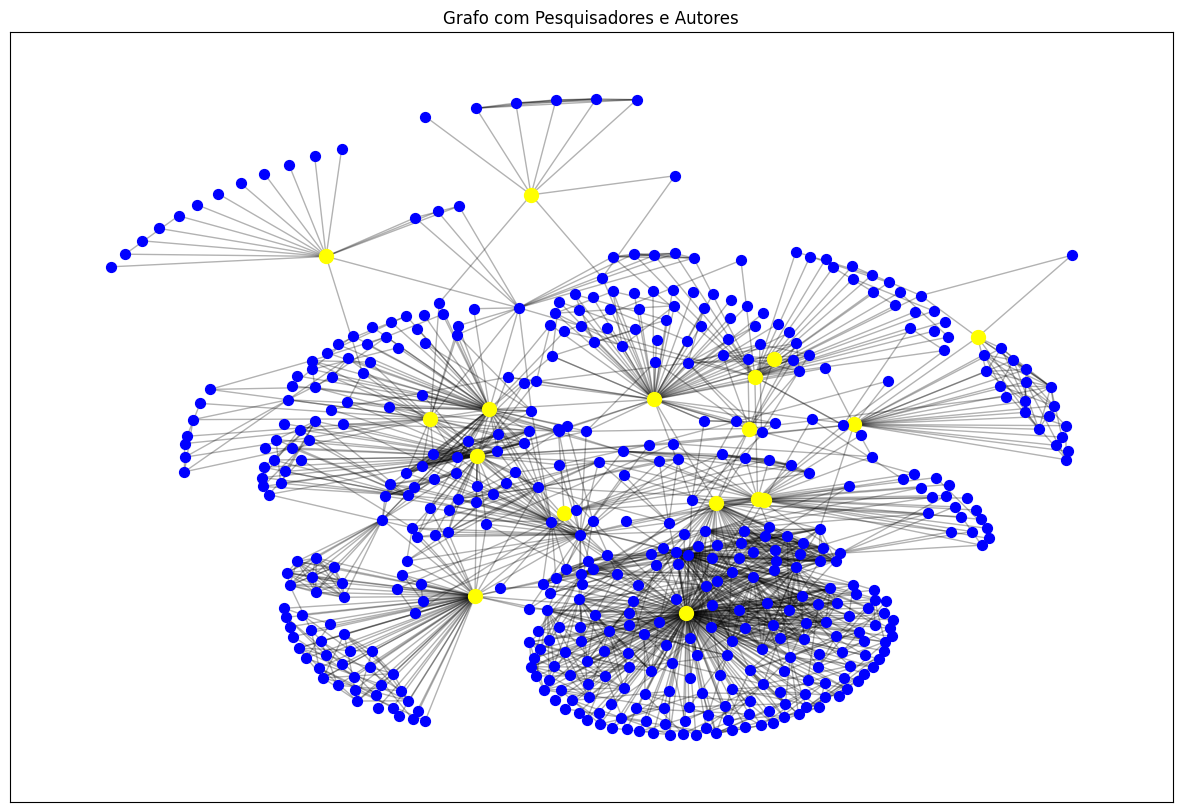

In [20]:
# Desenha grafo com pesquisadores e autores
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(g_pesquisadores_autores, scale=2, dim=2)
nx.draw_networkx_nodes(g_pesquisadores_autores, pos, node_size=100, nodelist=pesquisadores_node_list, node_color="yellow")
nx.draw_networkx_nodes(g_pesquisadores_autores, pos, node_size=50, nodelist=autores_node_list, node_color="blue")
nx.draw_networkx_edges(g_pesquisadores_autores, pos, alpha=0.3)
#_ = nx.draw_networkx_labels(g_pesquisadores_autores, pos, labels=label_list)
plt.title("Grafo com Pesquisadores e Autores")
plt.show()
limpa_listas()

### Instancia grafo e insere nodes e arestas para representar pesquisadores e orientados de mestrado e doutorado

In [21]:
g_pesquisadores_orientados = nx.Graph()
adiciona_pesquisadores_ao_grafo(g_pesquisadores_orientados)
adiciona_orientados_ao_grafo(g_pesquisadores_orientados)

### Desenha grafo apenas com pesquisadores e orientados de mestrado e doutorado
#### Define cores para os nodes de acordo com sua classificação
Legenda dos nodes:
* Pesquisadores Analisados -> amarelo
* Orientados de Mestrado -> azul
* Orientados de Doutorado -> verde

Obs: Caso queira analisar o grafo junto com o nome dos pesquisadores analisados (vértices amarelos), basta descomentar a linha de código comentada no bloco

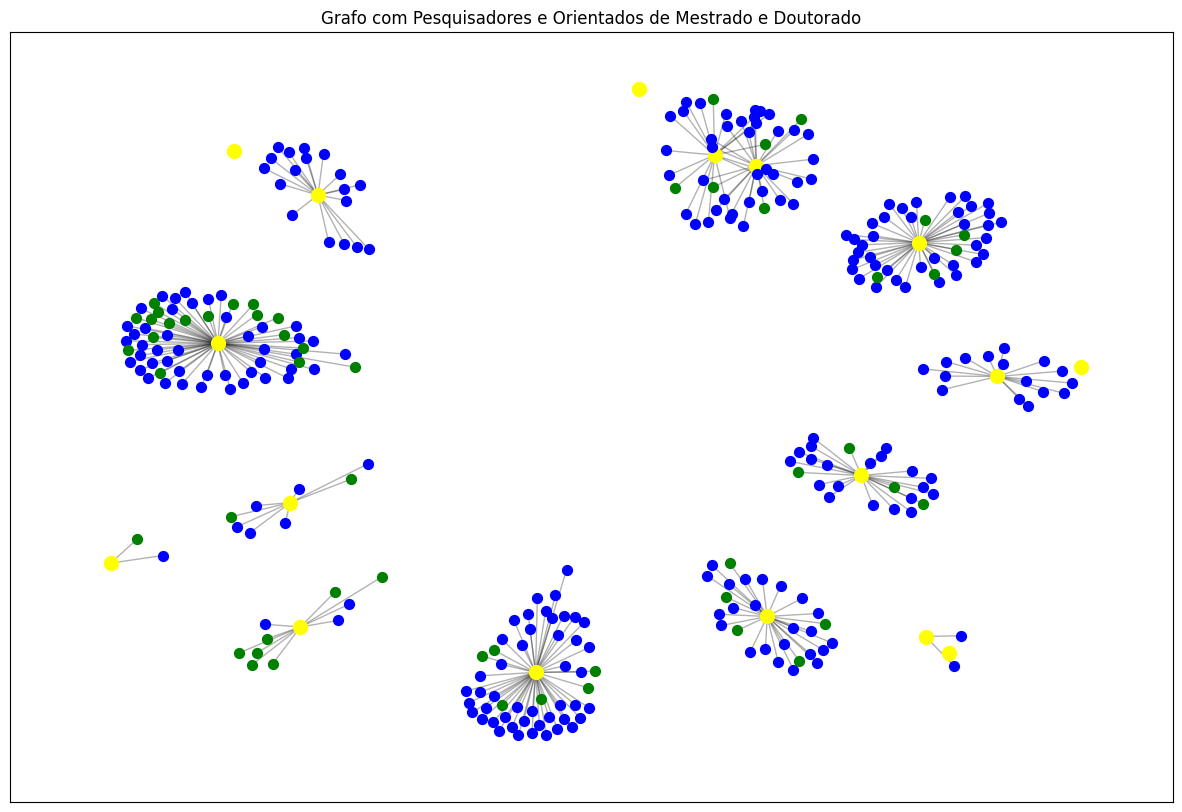

In [22]:
# Desenha grafo com pesquisadores e orientados de mestrado e doutorado
plt.figure(figsize=(15, 10))
pos = nx.fruchterman_reingold_layout(g_pesquisadores_orientados, k=0.12)
nx.draw_networkx_nodes(g_pesquisadores_orientados, pos, node_size=100, nodelist=pesquisadores_node_list, node_color="yellow")
nx.draw_networkx_nodes(g_pesquisadores_orientados, pos, node_size=50, nodelist=orientados_mestrado_node_list, node_color="blue")
nx.draw_networkx_nodes(g_pesquisadores_orientados, pos, node_size=50, nodelist=orientados_doutorado_node_list, node_color="green")
nx.draw_networkx_edges(g_pesquisadores_orientados, pos, alpha=0.3)
#_ = nx.draw_networkx_labels(g_pesquisadores_orientados, pos, labels=label_list)
plt.title("Grafo com Pesquisadores e Orientados de Mestrado e Doutorado")
plt.show()
limpa_listas()


### Instancia grafo e insere nodes e arestas para representar pesquisadores, co-autores e orientados de mestrado e doutorado

In [23]:
g_com_todos_os_individuos = nx.Graph()
adiciona_pesquisadores_ao_grafo(g_com_todos_os_individuos)
adiciona_autores_ao_grafo(g_com_todos_os_individuos, False)
adiciona_orientados_ao_grafo(g_com_todos_os_individuos)

### Desenha grafo com pesquisadores, co-autores e orientados de mestrado e doutorado
#### Define cores para os nodes de acordo com sua classificação
Legenda dos nodes:
* Pesquisadores Analisados -> vermelho
* Apenas Co-autor -> azul
* Apenas Orientado (Mestrado ou Doutorado) -> verde
* Co-autor e Orientado (Mestrado ou Doutorado) -> amarelo

Obs: Caso queira analisar o grafo junto com o nome dos pesquisadores analisados (vértices vermelhos), basta descomentar a linha de código comentada no bloco

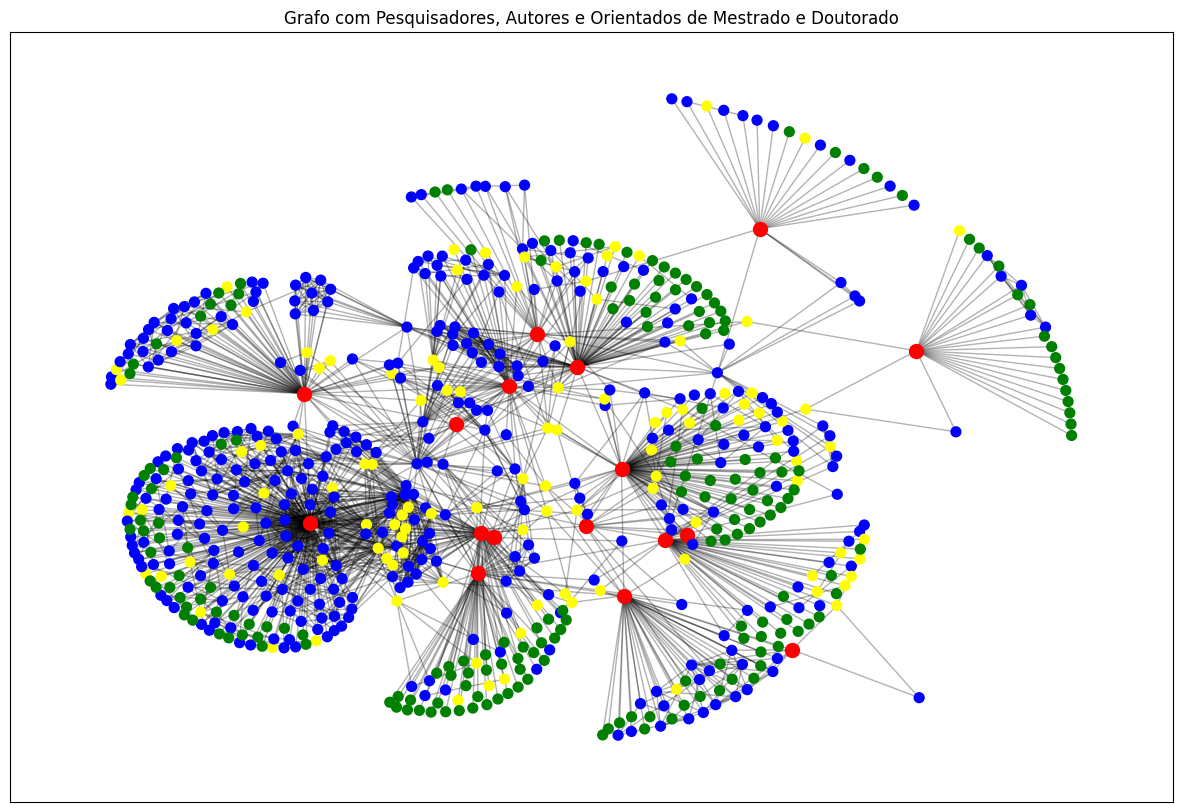

In [24]:
# Desenha grafo com pesquisadores, autores, e orientados de mestrado e doutorado
node_colors = retorna_cores_para_grafo_com_todos_os_individuos(g_com_todos_os_individuos)
node_list = autores_node_list + orientados_mestrado_node_list + orientados_doutorado_node_list
plt.figure(figsize=(15, 10))
pos = nx.kamada_kawai_layout(g_com_todos_os_individuos, scale=2, dim=2)
nx.draw_networkx_nodes(g_com_todos_os_individuos, pos, node_size=100, nodelist=pesquisadores_node_list, node_color="red")
nx.draw_networkx_nodes(g_com_todos_os_individuos, pos, node_size=50, nodelist=node_list, node_color=node_colors)
nx.draw_networkx_edges(g_com_todos_os_individuos, pos, alpha=0.3)
#_ = nx.draw_networkx_labels(g_com_todos_os_individuos, pos, labels=label_list)
plt.title("Grafo com Pesquisadores, Autores e Orientados de Mestrado e Doutorado")
plt.show()
limpa_listas()

#### No grafo acima podemos ver as relações entre os vértices amarelos, que representariam colaborações entre pesquisadores de um mesmo orientador.
#### Um conjunto de vértices amarelos que se conectam pode ser considerado um cluster de pesquisadores, que tem em comum o mesmo orientador.
<hr>

### Coeficiente de clustering para cada node de pesquisador que também é orientado
##### A saída está disponível no arquivo `clustering.txt`

In [25]:
# Identificando clusters de pesquisadores que foram orientados
with open("clustering.txt", "w+") as file:
    file.write("Coeficiente de clusters para cada node de pesquisadores com o mesmo orientador\n")
    print("Coeficiente de clusters para cada node de pesquisadores com o mesmo orientador")
    clusters = nx.clustering(g_com_todos_os_individuos, nodes=autores_orientados_node_list)
    file.write(f"Dados de clustering: {clusters}")
    print(clusters)

Coeficiente de clusters para cada node de pesquisadores com o mesmo orientador
{'vivian brito': 0.47619047619047616, 'caroline laiza negherbon': 1.0, 'eliana pacheco morastoni': 1.0, 'camila da cunha nunes': 0.3333333333333333, 'marcelo mariano da rocha': 0, 'leandro ludwig': 0.4642857142857143, 'maria roseli rossi avila': 0.6666666666666666, 'ana lucia abrao latronico': 1.0, 'arilson thomaz junior': 0.7, 'guilherme augusto hilario lopes': 0.6, 'nina beatriz august': 0.7, 'monica flissak': 1.0, 'denis vicentainer': 0.6666666666666666, 'simone riske koch': 0.3333333333333333, 'martin stabel garrote': 0.21904761904761905, 'ana claudi moser': 0.5, 'julio cesar refosco': 0.9, 'charles carminati de lima': 0.5333333333333333, 'ronaldo leao de miranda': 0.3333333333333333, 'eliane maria martins': 0.8333333333333334, 'fausto cheida curadi': 0.5, 'alanildo gomes guimaraes': 0, 'arlete longhi weber': 0, 'valdir da silva': 0.4, 'kayua girardi': 1.0, 'stella nemetz': 1.0, 'andrei stock': 0.4, 'mar

### Cálculo de Degree Centrality
#### É uma informação que representa o número de conexões diretas de um pesquisador
##### Como a saída pode ser muito grande, salvamos o conteúdo no arquivo `degree_centrality.txt`

In [26]:
# Calcula Degree Centrality
with open("degree_centrality.txt", "w") as file:
    file.write("Degree Centrality\n")
    print("Degree Centrality")
    degree_centrality = nx.degree_centrality(g_com_todos_os_individuos)
    print(degree_centrality)
    for node, centrality in degree_centrality.items():
        file.write(f"{node}: {centrality}\n")

Degree Centrality
{'luciana butzke': 0.019943019943019943, 'marcos antonio mattedi': 0.11965811965811966, 'tarcisio alfonso wickert': 0.011396011396011397, 'gilberto friedenreich dos santos': 0.07122507122507123, 'nelson afonso garcia santos': 0.002849002849002849, 'ivo marcos theis': 0.13105413105413105, 'luciano felix florit': 0.07834757834757836, 'leonardo brandao': 0.03133903133903134, 'lilian blanck de oliveira': 0.06410256410256411, 'marilda rosa galvao checcucci goncalves da silva': 0.03418803418803419, 'juares jose aumond': 0.10398860398860399, 'halina macedo leal': 0.004273504273504274, 'oklinger mantovaneli junior': 0.08974358974358974, 'maiko rafael spiess': 0.044159544159544165, 'carlos alberto cioce sampaio': 0.32621082621082625, 'valmor schiochet': 0.06125356125356125, 'germano adolfo gehrke': 0.005698005698005698, 'paulo henrique freire vieira': 0.004273504273504274, 'iara k. rischbieter': 0.005698005698005698, 'mariana c. linder': 0.008547008547008548, 'diego b. vargas'

### Cálculo de Betweenness Centrality
#### É uma informação que representa a medida de um vértice que atua como ponte entre outros vértices
##### Como a saída pode ser muito grande, salvamos o conteúdo no arquivo `betweenness_centrality.txt`

In [27]:
# Calcula Betweenness Centrality
with open("betweenness_centrality.txt", "w") as file:
    file.write("Betweenness Centrality\n")
    print("Betweenness Centrality")
    betweenness_centrality = nx.betweenness_centrality(g_com_todos_os_individuos)
    print(betweenness_centrality)
    for node, centrality in betweenness_centrality.items():
        file.write(f"{node}: {centrality}\n")

Betweenness Centrality
{'luciana butzke': 0.01034524775515915, 'marcos antonio mattedi': 0.20786478890636206, 'tarcisio alfonso wickert': 0.002093497629403838, 'gilberto friedenreich dos santos': 0.10917596258453673, 'nelson afonso garcia santos': 0.0, 'ivo marcos theis': 0.28163908236477514, 'luciano felix florit': 0.17355074126569237, 'leonardo brandao': 0.047766423863375124, 'lilian blanck de oliveira': 0.11753036248563883, 'marilda rosa galvao checcucci goncalves da silva': 0.0584566285232001, 'juares jose aumond': 0.1520391484076241, 'halina macedo leal': 8.128396145514547e-06, 'oklinger mantovaneli junior': 0.12950874375093208, 'maiko rafael spiess': 0.03505289097958438, 'carlos alberto cioce sampaio': 0.4489353878488797, 'valmor schiochet': 0.10520430689078643, 'germano adolfo gehrke': 1.6256792291029094e-05, 'paulo henrique freire vieira': 0.0023982312147063064, 'iara k. rischbieter': 0.0, 'mariana c. linder': 5.418930763676364e-06, 'diego b. vargas': 0.0, 'thaise vila nova': 0

### Identificação de Comunidades de Pesquisadores
#### O código abaixo identifica as principais comunidades de pesquisadores do grafo, colorindo-as para destacar. Após isso, o código desenha o grafo.

Obs: Caso queira analisar o grafo junto com o nome dos pesquisadores analisados (que os currículos foram fornecidos), basta descomentar a linha de código comentada no bloco

Número de comunidades detectadas: 13


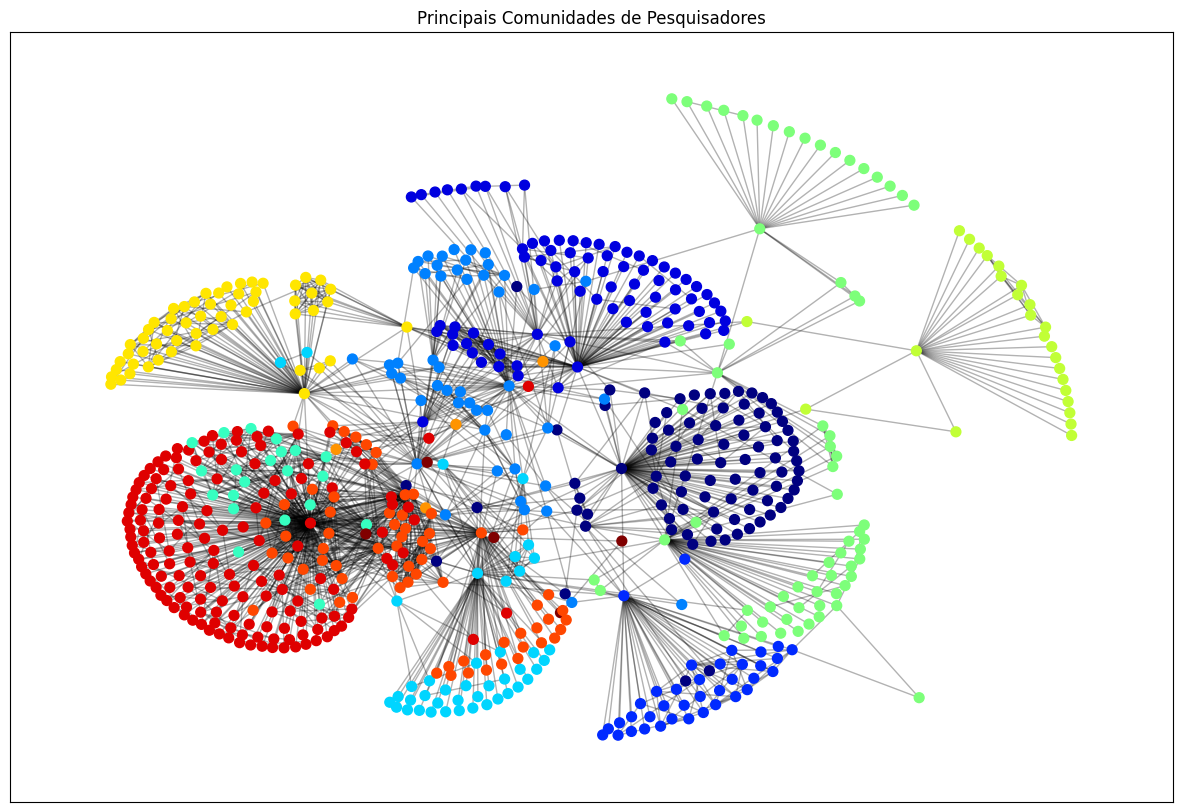

In [28]:
# Identifica comunidades entre pesquisadores
partition = community_louvain.best_partition(g_com_todos_os_individuos)
plt.figure(figsize=(15, 10))
colors = [partition[node] for node in g_com_todos_os_individuos.nodes]
nx.draw_networkx_nodes(g_com_todos_os_individuos, pos, node_size=50, node_color=colors, cmap=plt.cm.jet)
nx.draw_networkx_edges(g_com_todos_os_individuos, pos, alpha=0.3)
# nx.draw_networkx_labels(g_com_todos_os_individuos, pos, labels=label_list, font_size=10)
num_clusters = len(set(partition.values()))
print(f'Número de comunidades detectadas: {num_clusters}')
plt.title("Principais Comunidades de Pesquisadores")
plt.show()

### Cálculo de Densidade do Grafo
##### A saída está disponível no arquivo `densidade.txt`

In [29]:
# Calcula a densidade do grafo
with open("densidade.txt", "w") as file:
    print("Densidade do grafo: ", end="")
    densidade_grafo = nx.density(g_com_todos_os_individuos)
    print(densidade_grafo)
    file.write(f"Densidade do grafo: {densidade_grafo}")

Densidade do grafo: 0.007383902120744226


### Frequência de Colaborações Entre Pesquisadores
#### O código abaixo calcula a quantidade de vezes que uma ligação entre dois pesquisadores ocorre
##### Como a saída pode ser muito grande, salvamos o conteúdo no arquivo `frequencia_colaboracoes.txt`

In [30]:
# Frequencia de colaborações entre pesquisadores
# Essas frequencias sao contabilizadas na funcao adiciona_aresta_e_contabiliza_relacao
# As frequencias sao divididas por 2 pois cada aresta é contada 2 vezes. Sendo um par de vértices (u, v), é contada como (u, v) e (v, u).
with open("frequencia_colaboracoes.txt", "w") as file:
    file.write("Identificação de Padrões de Coautoria e Frequência de Colaborações:\n")
    print("Identificação de Padrões de Coautoria e Frequência de Colaborações")
    for pair, freq in coautoria_frequente.items():
        freq = int(freq/2)
        print(f"{pair[0]} e {pair[1]}:  {freq} vezes\n")
        file.write(f"{pair[0]} e {pair[1]}:  {freq} vezes\n")

Identificação de Padrões de Coautoria e Frequência de Colaborações
luciana butzke e paulo henrique freire vieira:  1 vezes

ivo marcos theis e luciana butzke:  25 vezes

iara k. rischbieter e ivo marcos theis:  1 vezes

ivo marcos theis e mariana c. linder:  2 vezes

diego b. vargas e ivo marcos theis:  1 vezes

iara k. rischbieter e luciana butzke:  1 vezes

luciana butzke e mariana c. linder:  2 vezes

diego b. vargas e luciana butzke:  1 vezes

iara k. rischbieter e mariana c. linder:  1 vezes

diego b. vargas e iara k. rischbieter:  1 vezes

diego b. vargas e mariana c. linder:  1 vezes

luciana butzke e thaise vila nova:  1 vezes

luciana butzke e oklinger mantovaneli junior:  6 vezes

ivo marcos theis e oklinger mantovaneli junior:  10 vezes

luciana butzke e vivian brito:  4 vezes

caroline laiza negherbon e vivian brito:  4 vezes

ivo marcos theis e vivian brito:  8 vezes

caroline laiza negherbon e luciana butzke:  5 vezes

caroline laiza negherbon e ivo marcos theis:  4 vezes

### Probabilidade de Colaboração Entre Pesquisadors com o Mesmo Orientador
O código abaixo calcula a probabilidade de colaboração entre pesquisadores com o mesmo orientador.<br>
Primeiro pega os nodes do grafo com pesquisadores e orientados, então atribui cada orientado ao seu orientador, e então soma a um total de colaborações possíveis e orientandos. Por fim calcula a probabilidade de haver uma colaboração entre os orientandos.

In [31]:
# Probabilidade de colaboração entre pesquisadores que possuem o mesmo orientador
# Função para contar as colaborações possíveis
def contar_colaboracoes_possiveis(grupo_orientados):
    n = len(grupo_orientados)
    if n < 2:
        return 0
    return n * (n - 1) // 2  # Combinação de 2 elementos de n (C(n, 2))

orientadores = {}
nodes = g_pesquisadores_orientados.nodes(data="orientador", default="")
for orientado, orientador in nodes:
    if orientador == "":
        if orientado not in orientadores.keys():
            orientadores[orientado] = []
        continue

    if orientador not in orientadores.keys():
        orientadores[orientador] = []
    orientadores[orientador].append(orientado)
        
total_colaboracoes_possiveis = 0
total_orientandos = 0
for orientador, grupo in orientadores.items():
    num_colaboracoes_possiveis = contar_colaboracoes_possiveis(grupo)
    total_colaboracoes_possiveis += num_colaboracoes_possiveis
    total_orientandos += len(grupo)
    print(f"Orientador {orientador}: {len(grupo)} orientandos, {num_colaboracoes_possiveis} colaborações possíveis")

# Calculando a probabilidade de colaboração
probabilidade_colaboracao = total_colaboracoes_possiveis / (total_orientandos * (total_orientandos - 1) / 2) if total_orientandos > 1 else 0
print(f"{probabilidade_colaboracao * 100:.2f}%")

Orientador luciana butzke: 2 orientandos, 1 colaborações possíveis
Orientador marcos antonio mattedi: 43 orientandos, 903 colaborações possíveis
Orientador tarcisio alfonso wickert: 0 orientandos, 0 colaborações possíveis
Orientador gilberto friedenreich dos santos: 10 orientandos, 45 colaborações possíveis
Orientador nelson afonso garcia santos: 0 orientandos, 0 colaborações possíveis
Orientador ivo marcos theis: 52 orientandos, 1326 colaborações possíveis
Orientador luciano felix florit: 28 orientandos, 378 colaborações possíveis
Orientador leonardo brandao: 8 orientandos, 28 colaborações possíveis
Orientador lilian blanck de oliveira: 24 orientandos, 276 colaborações possíveis
Orientador marilda rosa galvao checcucci goncalves da silva: 16 orientandos, 120 colaborações possíveis
Orientador juares jose aumond: 19 orientandos, 171 colaborações possíveis
Orientador halina macedo leal: 0 orientandos, 0 colaborações possíveis
Orientador oklinger mantovaneli junior: 26 orientandos, 325 co

### Cálculo de Assortatividade Entre Pesquisadores com o Mesmo Orientador
Assortatividade é tendência de um node se conectar com outros nodes similares. Um grafo assortativo é um grafo onde os nodes tendem a se conectar com outros nodes que são similares. Um grafo dissortativo é um grafo onde os nodes tendem a se conectar com outros nodes que não são similares.<br>
O código abaixo utiliza a biblioteca networkx para efetuar o cálculo de assortatividade baseado no orientador dos pesquisadores.<br>
Para isso, cria um novo grafo onde serão inseridos apenas os orientandos e suas ligações por publicações.<br>
O código também plota o grafo construído, destacando a falta de conexões entre os orientandos

Assortatividade: -0.38921046205995147


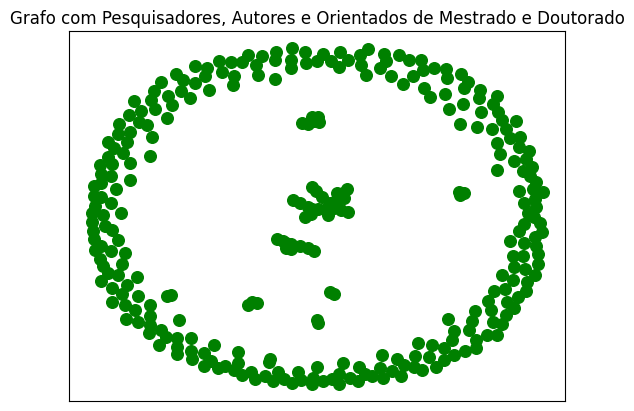

In [32]:
# Assortatividade
orientandos = list(map(lambda x: (x[0], {"orientador": x[1]}), filter(lambda x: x[1], nodes)))
g_orientandos = nx.Graph()
g_orientandos.add_nodes_from(orientandos)
for i in orientandos:
    for j in orientandos:
        if g_com_todos_os_individuos.has_edge(i[0], j[0]):
            g_orientandos.add_edge(i[0], j[0])

assortatividade = nx.assortativity.attribute_assortativity_coefficient(g_pesquisadores_orientados, "orientador")
print("Assortatividade:", assortatividade)
pos = nx.fruchterman_reingold_layout(g_orientandos)
nx.draw_networkx_nodes(g_orientandos, pos, node_size=70, node_color="green")
nx.draw_networkx_edges(g_orientandos, pos)
plt.title("Grafo com Pesquisadores, Autores e Orientados de Mestrado e Doutorado")
plt.show()

Como podemos ver, a assortatividade deu um valor negativo, o que significa que o grafo é dissortativo, ou seja, os nodes tem menos tendência de se conectarem com outros nodes similares, no nosso caso, de pesquisadores similares